In [1]:
from sdm.utils import set_project_wd
set_project_wd()
import nest_asyncio
nest_asyncio.apply()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


# About
This notebookmgets lidar data which will be used for two purposes:
 - to generate the elevation data
 - to fill gaps in the woody vegetation data

In [9]:
urls = {
    "DTM_2m":"https://environment.data.gov.uk/image/rest/services/SURVEY/LIDAR_Composite_2m_DTM_2022_Elevation/ImageServer",
    "DSM_2m":"https://environment.data.gov.uk/image/rest/services/SURVEY/LIDAR_Composite_2m_First_Return_DSM_2022_Elevation/ImageServer",
}
dl_resolution = 10 # resolution of the downloaded data in meters

In [3]:
import geopandas as gpd
boundary = gpd.read_file("data/processed/boundary.geojson")

# DTM Data

In [4]:
from functools import cache
from sdm.extract import ImageTileDownloader
dtm_downloader = ImageTileDownloader(
    base_url=urls["DTM_2m"],
    cache_folder = "data/raw/big-files/dtm-2m-cache",
)

In [5]:
dtm_image = dtm_downloader.download_image(
    boundary.geometry[0], target_resolution=dl_resolution
)

## DSM Data

In [6]:
dsm_downloader = ImageTileDownloader(
    base_url=urls["DSM_2m"],
    cache_folder="data/raw/big-files/dsm-2m-cache",
)

dsm_image = dsm_downloader.download_image(
    boundary.geometry[0], target_resolution=dl_resolution
)

## Calculate Terrain Statistics

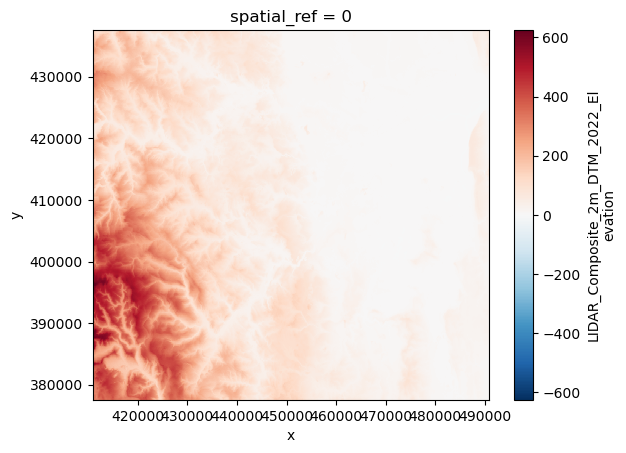

In [7]:
dtm_image.coarsen(x=10,y=10).mean().plot()

In [8]:
dtm_image

<xarray.DataArray 'LIDAR_Composite_2m_DTM_2022_Elevation' (y: 6000, x: 8000)>
dask.array<getitem, shape=(6000, 8000), dtype=float32, chunksize=(2000, 2000), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 4.109e+05 4.109e+05 ... 4.909e+05 4.909e+05
  * y            (y) float64 4.376e+05 4.376e+05 ... 3.776e+05 3.776e+05
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:    Area
    DataType:         Generic
    SourceBandIndex:  0

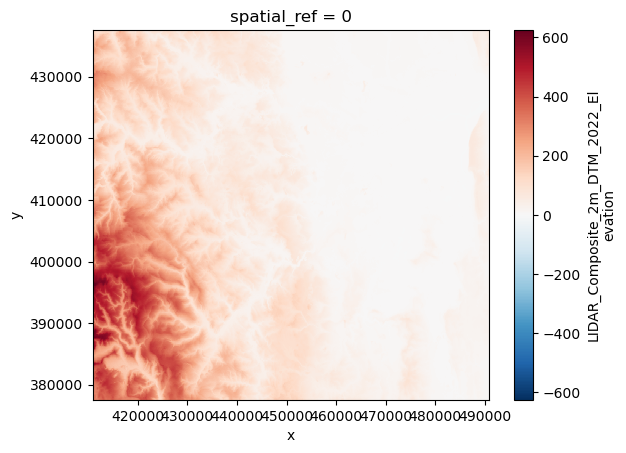

In [16]:
target_resolution = 100
scale_factor = round(target_resolution / dl_resolution)

dtm_100m = dtm_image.coarsen(x=scale_factor,y=scale_factor).mean().compute()
dtm_100m.plot()

# Write the DTM

In [17]:
dtm_100m.rio.to_raster("data/processed/dtm-100m.tif")